## Отбор пар акций

In [46]:
import numpy as np
import pandas as pd
from tqdm import tqdm

import os
import feather

import itertools
from itertools import product, combinations

import numba
from numba import njit, prange

import matplotlib.pyplot as plt

from sklearn import neighbors, linear_model
import statsmodels.api as sm
from statsmodels.tsa.stattools import grangercausalitytests

### 1. Подготовка датасета:

In [47]:
# загружаем все доступные тикеры по акциям США:
with open("tickers_list_total.txt", "r") as fp:
     tickers_list_total = json.load(fp)
all_tickers = tickers_list_total[0]
len(all_tickers)

8248

In [48]:
# возьмем все доступные даты со дня 'day' на основе дат акций Apple:
day = '2014-01-02'
ticker_name = 'AAPL'
parent_dir = 'C:/Users/Kuanysh/Downloads/pump_and_dump/all_tickers_daily_adj_feather'
file = os.path.join(parent_dir, ticker_name + '.feather')
df = pd.read_feather(file)
df.dropna(axis=0, how='all', inplace=True)
df_aapl = df[df['date']>=day]
df_aapl.set_index('date', inplace=True)
data = np.array([np.arange(len(df_aapl))]).T
df2 = pd.DataFrame(data, index=df_aapl.index, columns=['A'])

In [49]:
# соберем все тикеры, средний торговый оборот которых за поледние 5 лет > $1 млн., 
# также исключим из списка варранты и классы акций, если указаны явно через '-'
filtered_tickers = []
for i in tqdm(range(len(all_tickers))):
    ticker_name = all_tickers[i]
    parent_dir = 'C:/Users/Kuanysh/Downloads/pump_and_dump/all_tickers_daily_adj_feather'
    file = os.path.join(parent_dir, ticker_name + '.feather')
    df = pd.read_feather(file)
    df.dropna(axis=0, how='all', inplace=True)
    df1 = df[df['date']>=day]
    df1['trade_vol']=df1['close']*df1['volume']
    trade_vol_mean = df1['trade_vol'].mean()
    if len(df1)>=len(df2) and trade_vol_mean > 10e5 and len(ticker_name.split("-"))<2:
        filtered_tickers.append(ticker_name)

  0%|                                                                                         | 0/8248 [00:00<?, ?it/s]<ipython-input-49-330a170f3bae>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['trade_vol']=df1['close']*df1['volume']
100%|█████████████████████████████████████████████████████████████████████████████| 8248/8248 [01:01<00:00, 134.56it/s]


In [50]:
len(filtered_tickers)

2482

In [51]:
# по каждому тикеру из этого списка соберем датасет, по индексам дат Apple:
for i in tqdm(range(len(filtered_tickers))):
    ticker_name = filtered_tickers[i]
    parent_dir = 'C:/Users/Kuanysh/Downloads/pump_and_dump/all_tickers_daily_adj_feather'
    file = os.path.join(parent_dir, ticker_name + '.feather')
    df = pd.read_feather(file)
    df.dropna(axis=0, how='all', inplace=True)
    df1 = df[df['date']>=day]
    df1.set_index('date', inplace=True)
    df2 = pd.concat([df2, df1.close], axis=1)

100%|██████████████████████████████████████████████████████████████████████████████| 2482/2482 [01:49<00:00, 22.62it/s]


In [52]:
# заполним все пропущенные значения, предыдущими, а затем последующими ценами
df3 = df2.iloc[:len(df_aapl),1:].set_axis(filtered_tickers, axis=1, inplace=False)
for ticker in df3.columns:
    df3[ticker].fillna(method='ffill', inplace=True)
    df3[ticker].fillna(method='bfill', inplace=True)
np.where(df3.isna())

(array([], dtype=int64), array([], dtype=int64))

In [53]:
# на основе датасета цен, создадим датасет лог-доходностей
df4 = np.log(df3/df3.shift(1)).dropna()

In [54]:
# разделим датасеты на обучающую и тестовую выборки
train_loc = df4.index.get_loc(pd.to_datetime('2019-01-04'))
df5 = df4.iloc[:train_loc,:]
df6 = df3.iloc[:train_loc,:]

#df5.to_csv('df5_tot.csv')
#df6.to_csv('df6_tot.csv')

In [61]:
df5_test = df4.iloc[train_loc:,:]
df6_test = df3.iloc[train_loc:,:]

#df5_test.to_csv('df5_tot_test.csv')
#df6_test.to_csv('df6_tot_test.csv')

In [ ]:
# для упрощения расчетов создадим список комбинации всех тикеров из датасета
comb_list = np.array(list(combinations(df4.columns, 2))).tolist()
#np.save('comb_list.npy', comb_list)

### 2. Подходы к фильтрации пар акций

### 1) Cointegration

проверим линейную комбинацию двух рядов на стационарность

In [ ]:
# создадим датасет лог-цен
df7 = np.log(df6)

In [ ]:
def reg(x,y):
    regr = linear_model.LinearRegression()
    x_constant = pd.concat([x,pd.Series([1]*len(x),index = x.index)], axis=1)
    regr.fit(x_constant, y)    
    beta = regr.coef_[0]
    alpha = regr.intercept_
    spread = y - x*beta - alpha
    return spread

In [ ]:
# проведем сразу три теста на стационарность: 
#'n' - no constant, no trend 
#'c' - constant only
# 'ct' - constant and trend
def adfs(comb_list, df7):
    adf_stats = []
    for i in range(len(comb_list)):
        tickers = comb_list[i]
        x1 = df7[tickers[0]]
        x2 = df7[tickers[1]]
        spread = reg(x1,x2)
        adf1 = sm.tsa.stattools.adfuller(spread, maxlag=2, regression='n')
        adf2 = sm.tsa.stattools.adfuller(spread, maxlag=2, regression='c')
        adf3 = sm.tsa.stattools.adfuller(spread, maxlag=2, regression='ct')
        adf_stats.append([adf1[0], adf2[0], adf3[0]])
    return adf_stats

In [ ]:
adf_stats = adfs(comb_list, df7)

In [ ]:
# используем статистику на уровне 5%:
n5_stats = -1.9412157973333106
c5_stats = -2.863842063387667
ct5_stats = -3.4139885021964864

# конвертируем в бинарный ответ
adf_stats_tot[:,0] = 1*(adf_stats_tot[:,0]<n5_stats)
adf_stats_tot[:,1] = 1*(adf_stats_tot[:,1]<c5_stats)
adf_stats_tot[:,2] = 1*(adf_stats_tot[:,2]<ct5_stats)
#np.save('adf_stats_tot.npy', adf_stats)

### 2) Granger Causality

In [ ]:
def granger_causality_test(
    ticker_1, ticker_2, period="max", maxlag=15, column_to_test="Close", statistical_test='params_ftest',
    data=None, # preparsed stock prices
    verbose=False):
    
    gc_cols = [ticker_1, ticker_2]
    gc_raw = grangercausalitytests(
        data[gc_cols],
        maxlag=maxlag,
        verbose=verbose
    )    
    
    res = {
        lag: gc_raw[lag][0][statistical_test][1] for lag in range(1, maxlag+1)
    }
    
    return res

In [ ]:
dprices = df6.copy()
for i, col in enumerate(dprices.columns[1:]):
    dprices[col] = prices.iloc[:, i + 1].diff(1)

In [ ]:
stats = []
for ticket_1, ticket_2 in comb_list:
    gc1 = granger_causality_test(ticket_1, ticket_2, data=dprices, maxlag=2)
    gc2 = granger_causality_test(ticket_2, ticket_1, data=dprices, maxlag=2)
    stats.append([min(gc1.values()) <= 0.05, min(gc2.values()) <= 0.05])

In [ ]:
# получим бинарную маску
gc_stats_tot = 1*gc_stats
#np.save('gc_stats_tot.npy', gc_stats_tot)

### 3) Convergent Cross Mapping

In [28]:
def exp_weight(X):
    norm = X[:,[0]] +.00001
    numer = np.exp(-X/norm)
    denom = np.sum(numer,axis=1,keepdims=True)
    W = numer/denom
    return W  

def corrcoef(preds, actual):
    cc = np.corrcoef(preds,actual)[0,1]
    return cc

@njit(parallel=True)
def numba_embed_vectors_1d(X, lag, embed):
        tsize = X.shape[0]
        t_iter = tsize-(lag*(embed-1))
        features = np.zeros((t_iter,embed))
        for ii in prange(t_iter):
            end_val = ii+lag*(embed-1)+1
            part = X[ii : end_val]
            features[ii,:] = part[::lag]
        return features

In [29]:
class C_C_M:

    def __init__(self, weights='exp', verbose=False):
        self.weights = weights
        self.verbose = verbose

    def fit(self,X1,X2):

        self.X1 = X1
        self.X2 = X2

        near_neighs = X1.shape[1] + 2

        self.knn1 = neighbors.KNeighborsRegressor(near_neighs) #, n_jobs=-1
        self.knn2 = neighbors.KNeighborsRegressor(near_neighs) #, n_jobs=-1

    def predict(self,lib_lengths):

        X1_pred = []
        X2_pred = []

        for liblen in lib_lengths:

            x1_p = np.empty(self.X1.shape)
            x2_p = np.empty(self.X2.shape)

            self.knn1.fit(self.X1[:liblen], self.X1[:liblen])
            self.knn2.fit(self.X2[:liblen], self.X2[:liblen])

            dist1,ind1 = self.knn1.kneighbors(self.X1)
            dist2,ind2 = self.knn2.kneighbors(self.X2)

            dist1 = dist1[:,1:]
            dist2 = dist2[:,1:]
            ind1 = ind1[:,1:]
            ind2 = ind2[:,1:]

            for j in range(self.X1.shape[1]):

                W1 = exp_weight(dist1)
                W2 = exp_weight(dist2)

                x1_p[:, j] = np.sum(self.X1[ind2, j] * W2, axis=1)
                x2_p[:, j] = np.sum(self.X2[ind1, j] * W1, axis=1)

            X1_pred.append(x1_p)
            X2_pred.append(x2_p)

        self.X1_pred = X1_pred
        self.X2_pred = X2_pred

        return X1_pred, X2_pred

    def ccm_score(self):

        num_preds = self.X1.shape[1]

        score_1 = []
        score_2 = []

        for x1_p, x2_p in zip(self.X1_pred, self.X2_pred):

            sc1 = np.empty(num_preds)
            sc2 = np.empty(num_preds)

            for ii in range(num_preds):

                p1 = x1_p[:,ii]
                p2 = x2_p[:,ii]

                sc1[ii] = corrcoef(p1,self.X1[:,ii])
                sc2[ii] = corrcoef(p2,self.X2[:,ii])

            score_1.append(np.mean(sc1))
            score_2.append(np.mean(sc2))

        return score_1, score_2

In [30]:
def ccms(comb_list, df5):
    ccm_scores_mean = []
    ccm_scores_max = []
    for i in range(len(comb_list)):
        tickers = comb_list[i]
        x1_ = df5[tickers[0]].to_numpy()
        x2_ = df5[tickers[1]].to_numpy()
        lag = 1
        embed = 3
        X1 = numba_embed_vectors_1d(x1_, lag, embed)
        X2 = numba_embed_vectors_1d(x2_, lag, embed)
        lib_lens = np.array([125, 250, 500, 750, 1000, len(X1)], dtype='int')
        CCM = C_C_M()
        CCM.fit(X1,X2)
        x1p, x2p = CCM.predict(lib_lens)
        sc1, sc2 = CCM.ccm_score()
        ccm_scores_mean.append([np.mean(sc1), np.mean(sc2)])
        ccm_scores_max.append([np.max(sc1), np.max(sc2)])
    return ccm_scores_mean, ccm_scores_max

In [ ]:
ccm_scores_mean, ccm_scores_max = ccms(comb_list, df5)

In [ ]:
#np.save('ccm_max_tot.npy', ccm_scores_max)
#np.save('ccm_mean_tot.npy', ccm_scores_mean)

### 4) Pattern Causality

In [31]:
def pct_chg(arr):
    eps = 1e-6
    next_values = arr[:, :, 1::]
    prev_values = arr[:, :, 0:-1]
    prev_values[prev_values == 0] = eps
    chg = next_values / prev_values - 1
    return chg

def pattern_sig(arr, thr):
    arr[arr > thr ] = 1
    arr[arr < -thr ] = -1
    arr[(arr >= -thr ) & (arr <= thr)] = 0
    return arr.astype(int)

def to_str(arr):
    arr_ = arr.reshape(arr.shape[0], arr.shape[2]*2)
    arr__ = arr_.astype(str).tolist()
    arr_str = [",".join(string) for string in arr__]
    return arr_str

def PC_metrics(pred, actual):
    l, k = pred.shape
    x_stack_str = to_str(np.stack((pred, actual), 1).astype(np.int8))
    
    patterns = np.array(list(product(np.arange(-1, 2, 1), repeat=k)), dtype=np.int8)
    patterns_product = np.array(list(product(patterns, repeat=2)), dtype=np.int8)
    patterns_product_str = np.array(to_str(patterns_product))[:, np.newaxis]
    
    m = int(patterns_product.shape[0]**(1/2))
    indices = np.array([[i,j] for i in range(m) for j in range(m)])
    pattern_grid = np.hstack((patterns_product_str, indices))
    
    x_unique = np.unique(x_stack_str, return_counts = True)
    x_unique_df = pd.DataFrame(x_unique[1], index = x_unique[0], columns = ['counts'])
    pattern_grid_df = pd.DataFrame(pattern_grid[:,1:], index = pattern_grid[:,0], columns=['x', 'y'])
    total_counts = pattern_grid_df.join(x_unique_df)
    total_counts.fillna(0, inplace=True)
    total_counts_arr = total_counts.to_numpy().astype(int)
    
    confusion_matrix = np.zeros((m, m))
    for pat in total_counts_arr:
        confusion_matrix[pat[0], pat[1]] = pat[2]
    confusion_matrix /= l
        
    PC_pos = np.trace(confusion_matrix)
    PC_neg = np.trace(np.fliplr(confusion_matrix))
    if (m % 2) == 0:
        PC_dark = 1 - (PC_pos + PC_neg)
    else:
        PC_dark = 1 - (PC_pos + PC_neg) + np.median(np.diag(confusion_matrix))
            
    return PC_pos, PC_neg, PC_dark

In [32]:
class PatternCausality:

    def __init__(self, weights='exp', verbose=False):
        self.weights = weights
        self.verbose = verbose    
    
    def fit(self, X1, X2, x1, x2):

        self.X1 = X1
        self.X2 = X2
        self.x1 = x1
        self.x2 = x2

        near_neighs = X1.shape[1] + 2

        self.knn1 = neighbors.KNeighborsRegressor(near_neighs, p = 2) #, weights='distance', algorithm='kd_tree'
        self.knn2 = neighbors.KNeighborsRegressor(near_neighs, p = 2) #, weights='distance', algorithm='kd_tree',

    def predict_stocks(self, lib_lengths, thr_rate, lag):

        X1_pred = []
        X2_pred = []
        
        X01_pred = []
        X02_pred = []
        
        eps =0.0001
        
        for liblen in lib_lengths:
            
            self.x1[:liblen][self.x1[:liblen]==0]=eps
            self.x2[:liblen][self.x2[:liblen]==0]=eps
            
            x1_ret = np.log(self.x1[:liblen] / self.x1[:liblen].shift(lag)).dropna().values
            x2_ret = np.log(self.x2[:liblen] / self.x2[:liblen].shift(lag)).dropna().values
            
            thr1 = thr_rate * np.std(x1_ret)
            thr2 = thr_rate * np.std(x2_ret)
            
            Signatures1 = np.empty((liblen, self.X1.shape[1] + 1, self.X1.shape[1] - 1))
            Signatures2 = np.empty((liblen, self.X1.shape[1] + 1, self.X1.shape[1] - 1))
            
            Signatures01 = np.empty((liblen, self.X1.shape[1] + 1, self.X1.shape[1] - 1))
            Signatures02 = np.empty((liblen, self.X1.shape[1] + 1, self.X1.shape[1] - 1))

            self.knn1.fit(self.X1[:liblen], self.X1[:liblen])
            self.knn2.fit(self.X2[:liblen], self.X2[:liblen])

            dist1,ind1 = self.knn1.kneighbors(self.X1[:liblen])
            dist2,ind2 = self.knn2.kneighbors(self.X2[:liblen])

            dist1 = dist1[:,1:]
            dist2 = dist2[:,1:]
            ind1 = ind1[:,1:]
            ind2 = ind2[:,1:]
            
            X1_ind2 = self.X1[ind2]
            X2_ind1 = self.X2[ind1]
            
            X1_ind1 = self.X1[ind1]
            X2_ind2 = self.X2[ind2]
            
            S1 = pct_chg(X1_ind2)
            S2 = pct_chg(X2_ind1)
            
            S01 = pct_chg(X1_ind1)
            S02 = pct_chg(X2_ind2)
            
            for j in range(self.X1.shape[1] + 1):

                W1 = exp_weight(dist1)
                W2 = exp_weight(dist2)

                Signatures1[:, j] = S1[:, j] * W2[:, [j]]
                Signatures2[:, j] = S2[:, j] * W1[:, [j]]

                Signatures01[:, j] = S01[:, j] * W1[:, [j]]
                Signatures02[:, j] = S02[:, j] * W2[:, [j]]
                
            x1_p = pattern_sig(np.sum(Signatures1, axis=1), thr1)
            x2_p = pattern_sig(np.sum(Signatures2, axis=1), thr2)

            x01_p = pattern_sig(np.sum(Signatures01, axis=1), thr1)
            x02_p = pattern_sig(np.sum(Signatures02, axis=1), thr2)

            X1_pred.append(x1_p)
            X2_pred.append(x2_p)
            
            X01_pred.append(x01_p)
            X02_pred.append(x02_p)
            
        self.X1_pred = X1_pred
        self.X2_pred = X2_pred
        
        self.X01_pred = X01_pred
        self.X02_pred = X02_pred

        return X1_pred, X2_pred, X01_pred, X02_pred
    
    def PC_score(self):
        
        score_1 = []
        score_2 = []

        for x1_p, x2_p, x01_p, x02_p in zip(self.X1_pred, self.X2_pred, self.X01_pred, self.X02_pred):

            PC_pos_xy, PC_neg_xy, PC_dark_xy = PC_metrics(x1_p, x01_p)
            PC_pos_yx, PC_neg_yx, PC_dark_yx = PC_metrics(x2_p, x02_p)

            score_1.append([PC_pos_xy, PC_neg_xy, PC_dark_xy])
            score_2.append([PC_pos_yx, PC_neg_yx, PC_dark_yx])

        return np.array(score_1), np.array(score_2)

In [33]:
def pcs(comb_list, df6):
    pc_scores_mean = []
    pc_scores_max = []
    for i in range(len(comb_list)):
        tickers = comb_list[i]
        
        x1_ = df6[tickers[0]]
        x2_ = df6[tickers[1]]
        
        x1 = df6[tickers[0]].to_numpy()
        x2 = df6[tickers[1]].to_numpy()

        lag = 1
        embed = 3
        X1 = numba_embed_vectors_1d(x1, lag, embed)
        X2 = numba_embed_vectors_1d(x2, lag, embed)
        lib_lens = np.array([125, 250, 500, 750, 1000, len(X1)], dtype='int')

        PC = PatternCausality()
        PC.fit(X1, X2, x1_, x2_)
        X1_pred, X2_pred, X01_pred, X02_pred = PC.predict_stocks(lib_lengths=lib_lens, thr_rate=0.001, lag=lag)

        sc1, sc2 = PC.PC_score()
        PC_pos_xy, PC_neg_xy, PC_dark_xy = sc1[:,0], sc1[:,1], sc1[:,2]
        PC_pos_yx, PC_neg_yx, PC_dark_yx = sc2[:,0], sc2[:,1], sc2[:,2]

        pc_scores_mean.append([np.mean(PC_pos_xy), np.mean(PC_pos_yx)])
        pc_scores_max.append([np.max(PC_pos_xy), np.max(PC_pos_yx)])
        
    return pc_scores_mean, pc_scores_max

In [ ]:
pc_scores_mean, pc_scores_max = pcs(comb_list, df6)

In [ ]:
#np.save('pc_max_tot.npy', pc_scores_max)
#np.save('pc_mean_tot.npy', pc_scores_mean)

### 3. Результаты

In [17]:
# загрузим все сохраненные результаты
comb_list_tot = np.load('comb_list_tot.npy')

df5_tot = pd.read_csv('df5_tot.csv', index_col = 'date')
df6_tot = pd.read_csv('df6_tot.csv', index_col = 'date')

adf_stats_tot = np.load('adf_stats_tot.npy').astype(int)
gc_stats_tot = np.load('gc_stats_tot.npy').astype(int)

ccm_max_tot = np.round(np.load('ccm_max_tot.npy'), 4)
ccm_mean_tot = np.round(np.load('ccm_mean_tot.npy'), 4)

pc_max_tot = np.round(np.load('pc_max_tot.npy'), 4)
pc_mean_tot = np.round(np.load('pc_mean_tot.npy'), 4)

In [18]:
# объединим все результаты в один датафрейм
tot_stats = np.hstack((comb_list_tot, adf_stats_tot, gc_stats_tot, ccm_max_tot, ccm_mean_tot, pc_max_tot, pc_mean_tot))
agg_df = pd.DataFrame(tot_stats, columns=['ticker_x', 'ticker_y', 'coint_df_n', 'coint_df_c', 'coint_df_ct', 'gc_x', 'gc_y', 
                                 'ccm_max_x', 'ccm_max_y', 'ccm_mean_x', 'ccm_mean_y',
                                 'pc_max_x', 'pc_max_y', 'pc_mean_x', 'pc_mean_y'])
agg_df['coint_df_n'] = agg_df['coint_df_n'].astype(int)
agg_df['coint_df_c'] = agg_df['coint_df_c'].astype(int)
agg_df['coint_df_ct'] = agg_df['coint_df_ct'].astype(int)
agg_df['gc_x'] = agg_df['gc_x'].astype(int)
agg_df['gc_y'] = agg_df['gc_y'].astype(int)
agg_df

,ticker_x,ticker_y,coint_df_n,coint_df_c,coint_df_ct,gc_x,gc_y,ccm_max_x,ccm_max_y,ccm_mean_x,ccm_mean_y,pc_max_x,pc_max_y,pc_mean_x,pc_mean_y
0,AAIC,AAMC,0,0,0,0,0,0.0598,0.103,0.0482,0.0734,0.416,0.364,0.3391,0.3268
1,AAIC,AAON,1,0,0,0,0,0.1411,0.1708,0.1345,0.1592,0.3341,0.316,0.3236,0.3009
2,AAIC,AAT,1,1,0,0,0,0.1772,0.2535,0.1521,0.2162,0.32,0.346,0.3051,0.321
3,AAIC,AB,1,0,0,0,0,0.1928,0.2365,0.1585,0.1942,0.3493,0.336,0.3115,0.3109
4,AAIC,ABEO,1,0,0,0,0,0.0511,0.0465,0.0313,0.0211,0.322,0.2689,0.3049,0.2296
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1142479,YELP,ZBH,1,1,0,1,0,0.1164,0.144,0.1052,0.1269,0.376,0.3053,0.3119,0.2889
1142480,YELP,ZTS,0,0,0,0,0,0.0846,0.132,0.0665,0.0842,0.344,0.346,0.3093,0.3268
1142481,YUM,ZBH,1,0,0,1,0,0.1745,0.2352,0.1341,0.2013,0.346,0.376,0.3172,0.338
1142482,YUM,ZTS,0,0,0,1,0,0.132,0.1902,0.1181,0.1615,0.3469,0.356,0.3066,0.3264


In [19]:
#agg_df.to_csv('agg_df.csv')

In [20]:
# всего акций для наблюдения (средний торговый оборот за поледние 5 лет > $1 млн.)
all_liquid_equities = np.unique(comb_list_tot)
all_liquid_equities.shape

(2482,)

In [42]:
def plot_ccm(tickers, df5):
    x1_ = df5[tickers[0]].to_numpy()
    x2_ = df5[tickers[1]].to_numpy()

    lag = 1
    embed = 3
    X1 = numba_embed_vectors_1d(x1_, lag, embed)
    X2 = numba_embed_vectors_1d(x2_, lag, embed)
    len_X1 = len(X1)
    lib_lens = np.linspace(10, len_X1, num=50, dtype='int')
    
    CCM = C_C_M()
    CCM.fit(X1,X2)
    x1p, x2p = CCM.predict(lib_lens)
    sc1, sc2 = CCM.ccm_score()
    
    plt.plot(lib_lens, sc1, color='b', label = str(tickers[0]))
    plt.plot(lib_lens, sc2, color='g', label = str(tickers[1]))
    plt.axvline(x=20, c='salmon', lw=0.5)
    plt.axvline(x=50, c='salmon', lw=0.5)
    plt.axvline(x=100, c='salmon', lw=0.5)
    plt.ylabel('forecast skill')
    plt.xlabel('lib length')
    plt.title('Convergent cross mapping ' + str(tickers[0]) + ' and ' +  str(tickers[1]))
    plt.legend()

def plot_pc(tickers, df6): 
    x1_ = df6[tickers[0]]
    x2_ = df6[tickers[1]]

    x1 = df6[tickers[0]].to_numpy()
    x2 = df6[tickers[1]].to_numpy()

    lag = 1
    embed = 3
    X1 = numba_embed_vectors_1d(x1,lag,embed)
    X2 = numba_embed_vectors_1d(x2,lag,embed)

    len_ts = len(X1)
    lib_lens = np.arange(10, len_ts, len_ts/50, dtype='int')

    PC = PatternCausality()
    PC.fit(X1, X2, x1_, x2_)
    X1_pred, X2_pred, X01_pred, X02_pred = PC.predict_stocks(lib_lengths=lib_lens, thr_rate=0.0001, lag=lag)

    sc1, sc2 = PC.PC_score()
    PC_pos_xy, PC_neg_xy, PC_dark_xy = sc1[:,0], sc1[:,1], sc1[:,2]
    PC_pos_yx, PC_neg_yx, PC_dark_yx = sc2[:,0], sc2[:,1], sc2[:,2]
    
    plt.plot(lib_lens, PC_pos_xy, color='royalblue', label = 'PC_pos_xy')
    plt.plot(lib_lens, PC_neg_xy, color='orange', label = 'PC_neg_xy')
    plt.plot(lib_lens, PC_dark_xy, color='violet', label = 'PC_dark_xy')

    plt.plot(lib_lens, PC_pos_yx, color='blue', label = 'PC_pos_yx')
    plt.plot(lib_lens, PC_neg_yx, color='orangered', label = 'PC_neg_yx')
    plt.plot(lib_lens, PC_dark_yx, color='darkviolet', label = 'PC_dark_yx')
    
    plt.axvline(x=20, c='salmon', lw=0.5)
    plt.axvline(x=50, c='salmon', lw=0.5)
    plt.axvline(x=100, c='salmon', lw=0.5)

    plt.ylabel('forecast skill')
    plt.xlabel('lib length')
    plt.title('Pattern Causality ' + str(tickers[0]) + ' and ' +  str(tickers[1]))
    plt.legend()
    
def plot_ccm_pc(list_of_tickers):
    for i in range(len(list_of_tickers)):
        plt.figure(figsize=(12,5))
        plt.subplot(1, 2, 1)
        plot_ccm(list_of_tickers[i], df5_tot)
        plt.subplot(1, 2, 2)
        plot_pc(list_of_tickers[i], df6_tot)
        plt.show()

#### 1. Топ-10 пар, когда как минимум на одном тестов Дики-Фуллера спред стационарен, а ccm, pc - максимальны.

In [91]:
df0 = agg_df[(agg_df.coint_df_n==1) | (agg_df.coint_df_c==1) | (agg_df.coint_df_ct==1)].sort_values(by=['pc_max_x', 'pc_max_y'], ascending=[False, False])[:10]
df0

,ticker_x,ticker_y,coint_df_n,coint_df_c,coint_df_ct,gc_x,gc_y,ccm_max_x,ccm_max_y,ccm_mean_x,ccm_mean_y,pc_max_x,pc_max_y,pc_mean_x,pc_mean_y
969086,NWS,NWSA,1,1,1,0,0,0.9319,0.9326,0.9081,0.9041,0.736,0.74,0.7084,0.6999
168021,CENT,CENTA,1,1,0,1,0,0.927,0.928,0.9017,0.9074,0.692,0.6993,0.6594,0.6675
1067569,BBD,ITUB,1,0,0,0,0,0.8199,0.7782,0.8083,0.747,0.69,0.69,0.6338,0.6208
539242,AMKR,PSXP,1,1,1,0,0,0.0741,0.1291,0.045,0.054,0.68,0.44,0.3836,0.305
560526,ARW,AVT,1,1,1,0,0,0.744,0.7392,0.7298,0.7236,0.666,0.638,0.6113,0.5882
680179,CM,RY,1,0,1,1,1,0.7547,0.7542,0.7201,0.7209,0.664,0.5537,0.5692,0.5303
283725,FCF,IBOC,1,1,1,1,1,0.7467,0.782,0.7347,0.7738,0.656,0.688,0.5856,0.5973
284145,FCF,TRMK,1,1,1,1,1,0.7799,0.8093,0.7554,0.7924,0.656,0.6307,0.6164,0.6058
1120018,KEY,RF,1,0,0,0,0,0.829,0.8169,0.8089,0.8058,0.6547,0.648,0.6224,0.6274
538857,AMKR,FUL,1,1,1,0,0,0.2269,0.262,0.2018,0.2431,0.648,0.36,0.4212,0.3439


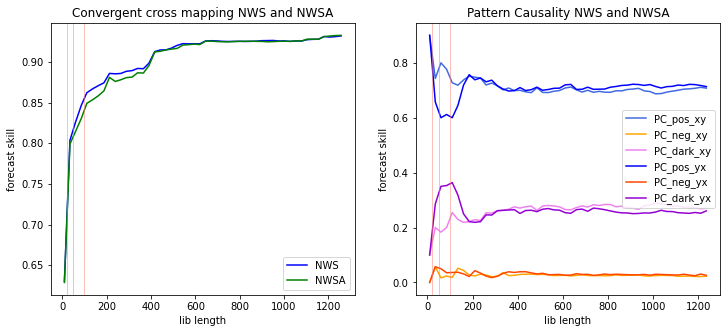

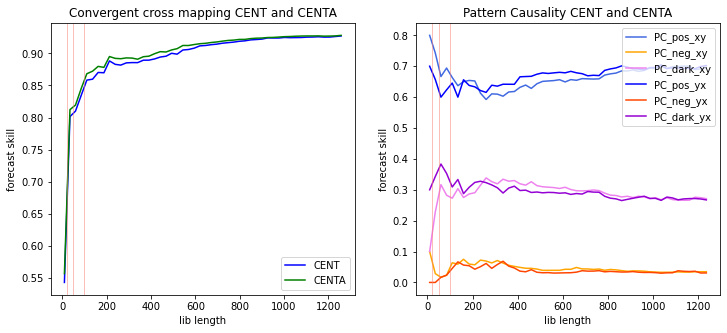

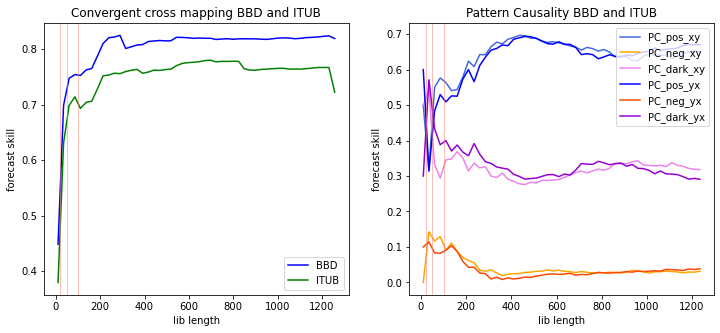

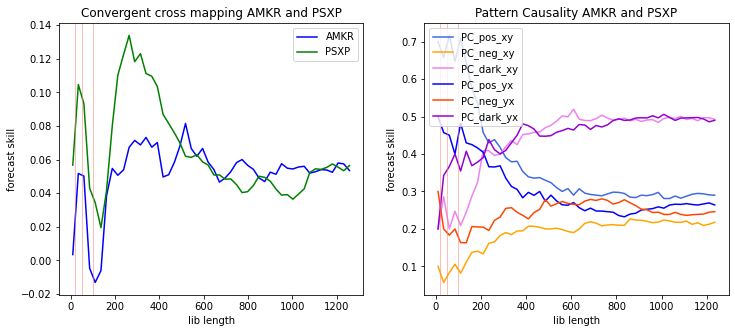

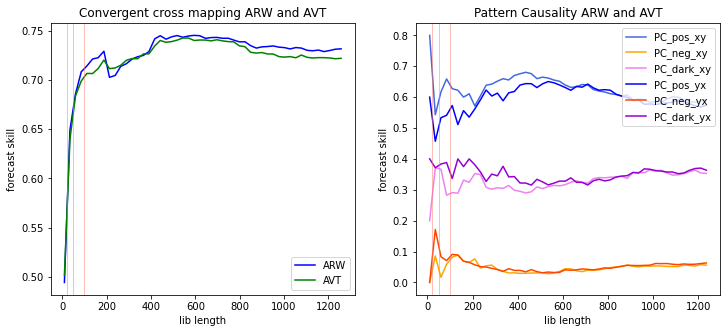

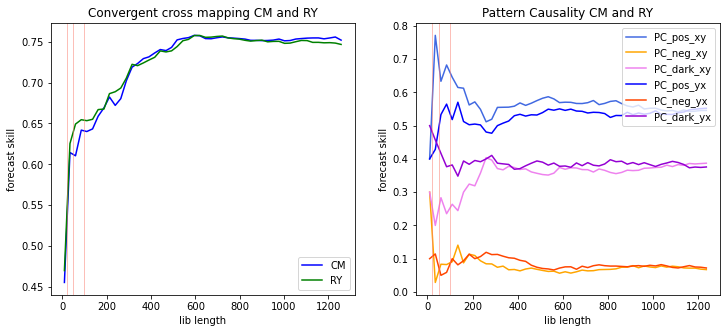

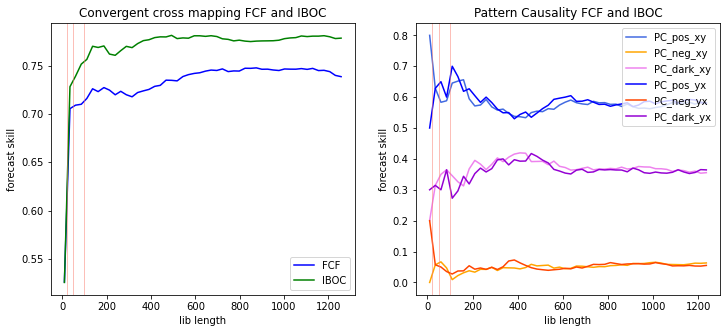

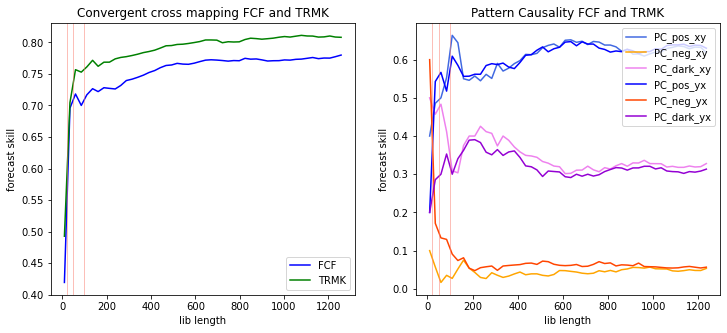

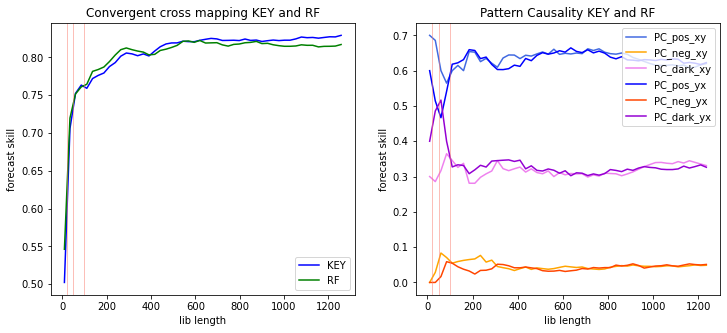

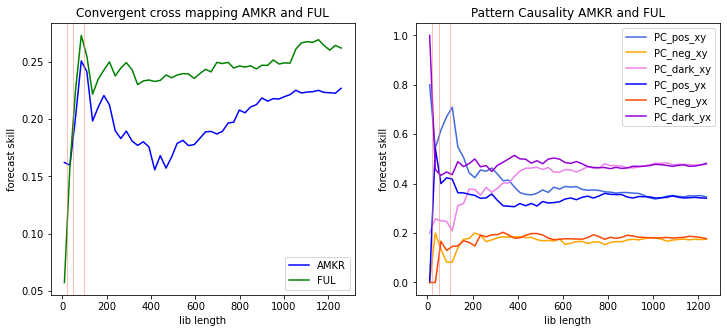

In [43]:
list0 = df0.iloc[:,:2].to_numpy()
plot_ccm_pc(list0)

#### 2. Топ-10 пар, когда как на всех тестах Дики-Фуллера спред нестационарен, а ccm и pc - максимальны.
Т.е. какое максимальное значение CCM и PC, при отсутствии коинтеграции.

In [89]:
df1 = agg_df[(agg_df.coint_df_n==0) & (agg_df.coint_df_c==0) & (agg_df.coint_df_ct==0)].sort_values(by=['pc_max_x', 'pc_max_y'], ascending=[False, False])[:10]
df1

,ticker_x,ticker_y,coint_df_n,coint_df_c,coint_df_ct,gc_x,gc_y,ccm_max_x,ccm_max_y,ccm_mean_x,ccm_mean_y,pc_max_x,pc_max_y,pc_mean_x,pc_mean_y
1136303,PNC,STT,0,0,0,0,0,0.6421,0.5908,0.6047,0.5721,0.696,0.54,0.5324,0.5051
618207,BMA,GGAL,0,0,0,1,0,0.7423,0.7413,0.7294,0.733,0.664,0.608,0.558,0.5257
539233,AMKR,PRG,0,0,0,0,0,0.0747,0.0859,0.0542,0.0617,0.656,0.384,0.3758,0.3092
1127074,MGM,WYNN,0,0,0,0,0,0.5959,0.5653,0.5526,0.5444,0.648,0.672,0.5374,0.534
538782,AMKR,EBIX,0,0,0,0,0,0.1419,0.1564,0.1145,0.1323,0.648,0.368,0.3792,0.3229
796413,FMBI,GBCI,0,0,0,0,0,0.7994,0.8046,0.7762,0.7836,0.6453,0.6453,0.603,0.5828
1126800,MET,PRU,0,0,0,1,1,0.8028,0.8246,0.7889,0.8105,0.642,0.658,0.5823,0.598
538657,AMKR,CBRE,0,0,0,0,1,0.1864,0.2507,0.1731,0.2419,0.64,0.376,0.4046,0.3212
689964,COLB,GBCI,0,0,0,1,1,0.8057,0.8029,0.7868,0.7889,0.6373,0.588,0.5845,0.5541
650884,CBU,FMBI,0,0,0,0,0,0.7713,0.7685,0.7567,0.7521,0.636,0.608,0.5814,0.5585


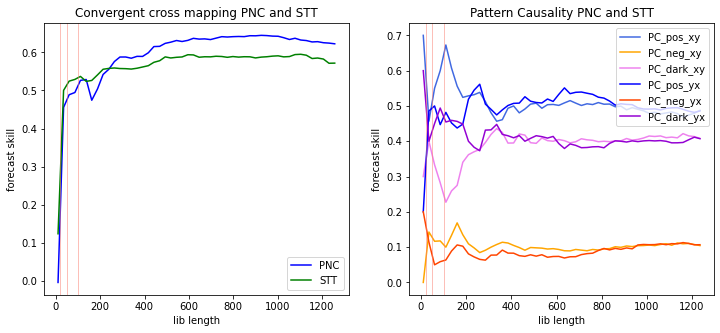

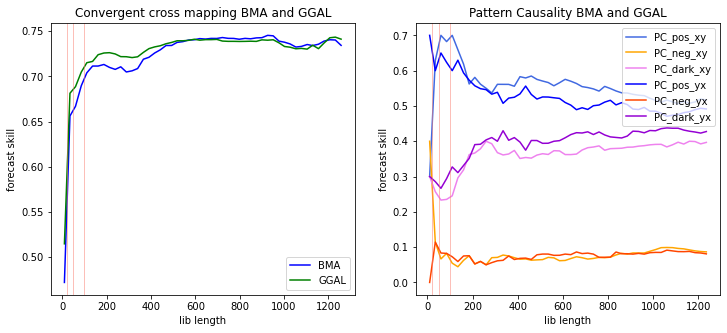

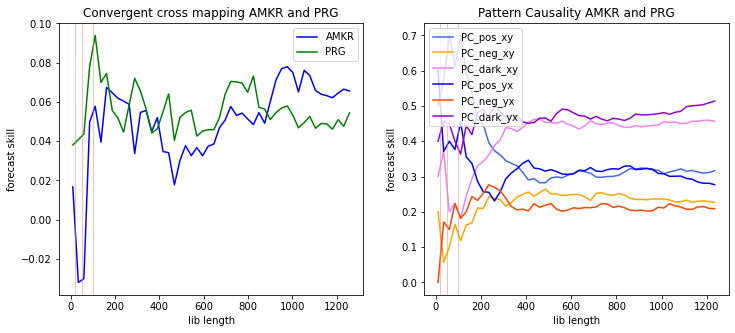

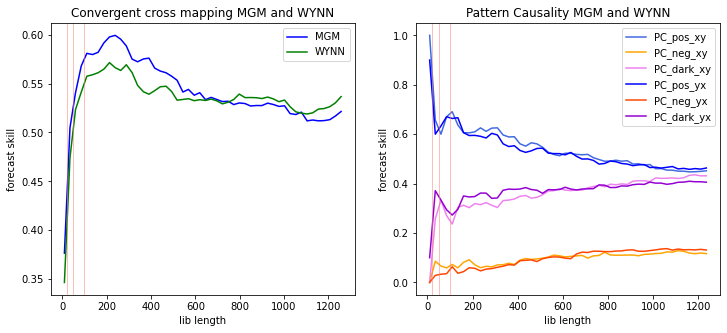

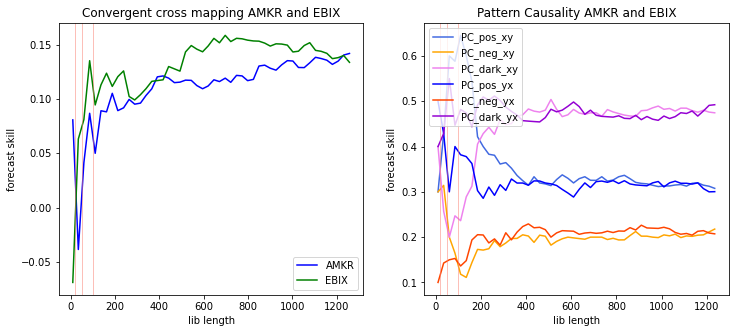

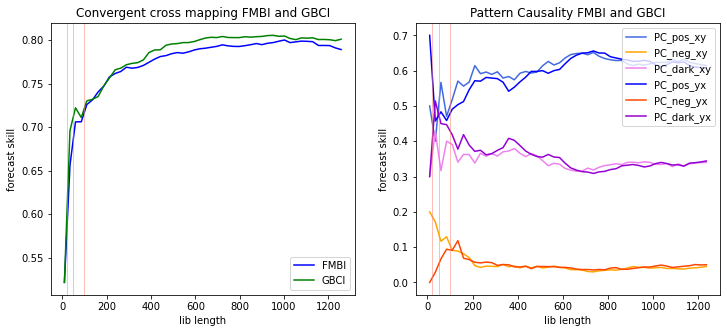

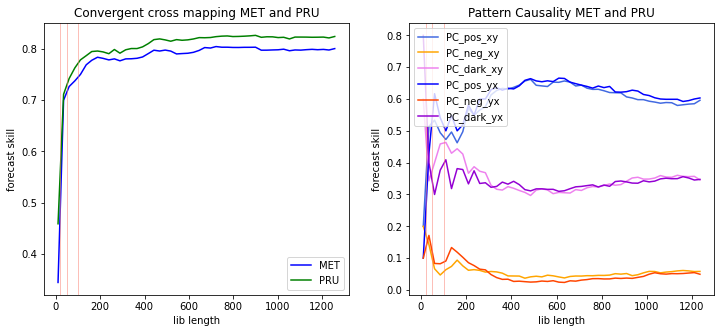

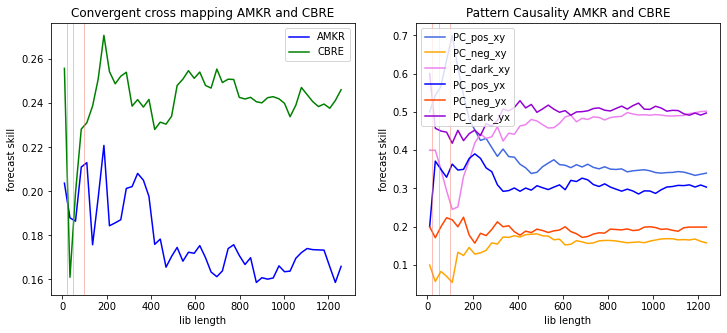

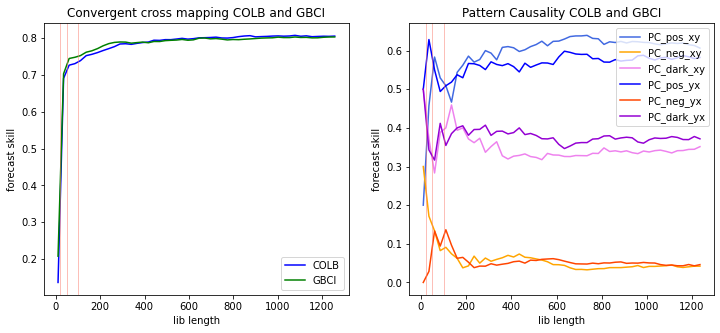

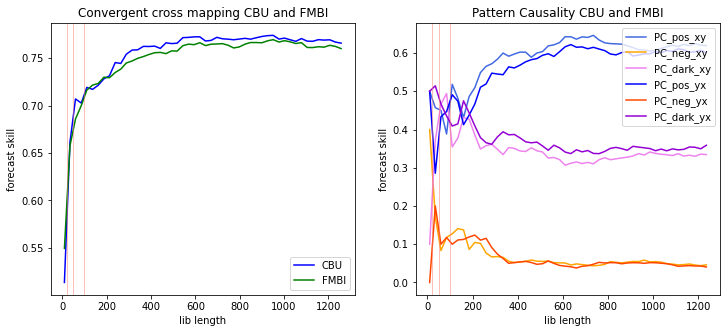

In [44]:
list1 = df1.iloc[:,:2].to_numpy()
plot_ccm_pc(list1)

#### 3. Топ-10 пар, когда как на всех тестах Дики-Фуллера спред нестационарен, ccm - минимально, а pc - максимально. 
Т.е. какое максимальное значение PC, при отсутствии коинтеграции и CCM взаимосвязей.

In [90]:
df2 = agg_df[(agg_df.coint_df_n==0) & (agg_df.coint_df_c==0) & (agg_df.coint_df_ct==0)].sort_values(by=['ccm_max_x', 'ccm_max_y', 'pc_max_x', 'pc_max_y'], ascending=[True, True, False, False])[:10]
df2

,ticker_x,ticker_y,coint_df_n,coint_df_c,coint_df_ct,gc_x,gc_y,ccm_max_x,ccm_max_y,ccm_mean_x,ccm_mean_y,pc_max_x,pc_max_y,pc_mean_x,pc_mean_y
173174,CGEN,MUX,0,0,0,0,0,-0.0,-0.0023,-0.0095,-0.0142,0.292,0.2506,0.2706,0.2315
322995,GRVY,SMLP,0,0,0,0,0,-0.0,-0.0046,-0.0127,-0.0289,0.264,0.272,0.2408,0.2495
156935,CBLI,EBR,0,0,0,0,0,-0.0,-0.0058,-0.0248,-0.01,0.336,0.268,0.28,0.2576
65563,AQN,BSQR,0,0,0,0,0,-0.0,-0.0081,-0.0063,-0.0243,0.296,0.272,0.2797,0.2439
510023,AG,CASY,0,0,0,0,0,-0.0,-0.0114,-0.0081,-0.0292,0.32,0.304,0.2596,0.2783
166004,CEI,MBWM,0,0,0,0,0,-0.0,-0.0166,-0.0035,-0.0262,0.2657,0.29,0.2518,0.2745
504109,AEM,ISEE,0,0,0,0,0,-0.0,0.0001,-0.0108,-0.0143,0.296,0.248,0.2291,0.2207
169307,CENTA,OTRK,0,0,0,0,1,-0.0,0.0059,-0.0132,-0.0144,0.344,0.242,0.3008,0.2071
166904,CELH,OEG,0,0,0,0,0,-0.0,0.0063,-0.0407,-0.0142,0.272,0.344,0.2626,0.2891
357246,IMMP,SYPR,0,0,0,0,0,-0.0,0.0083,-0.0081,0.0004,0.28,0.284,0.2596,0.2677


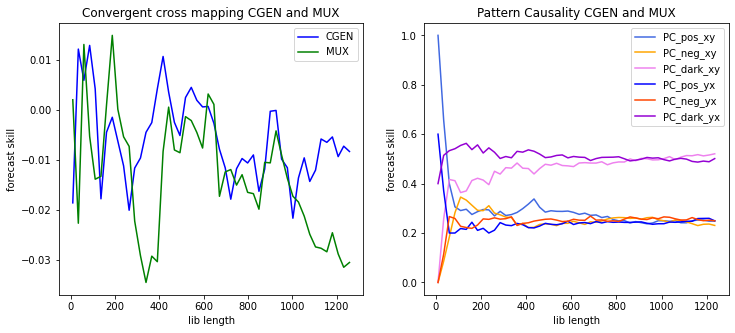

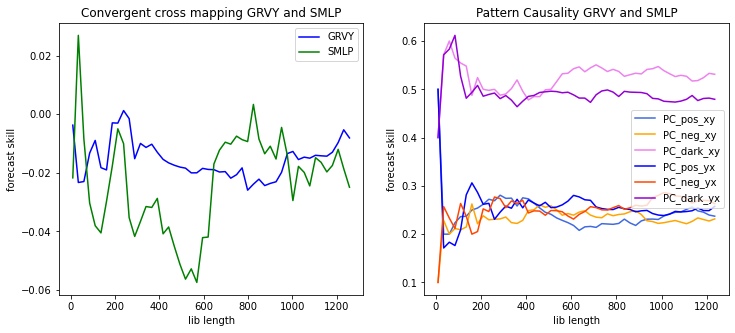

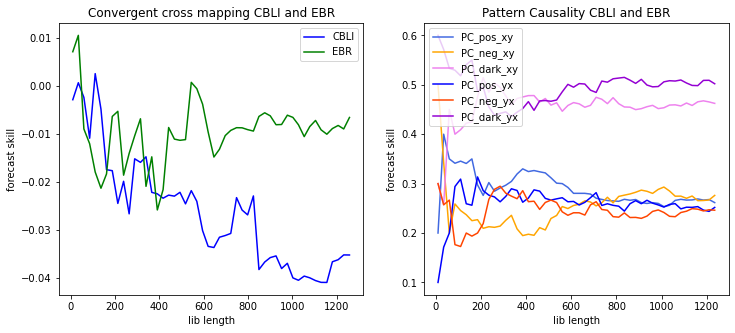

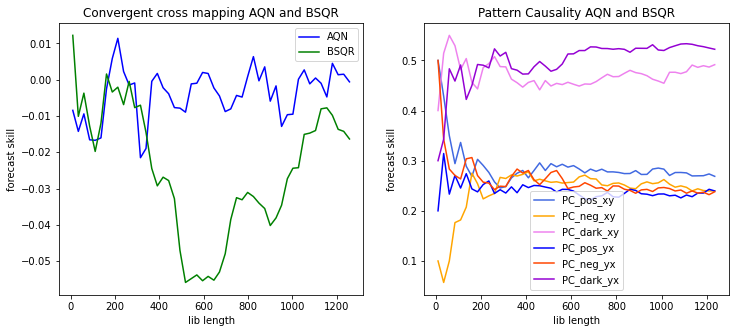

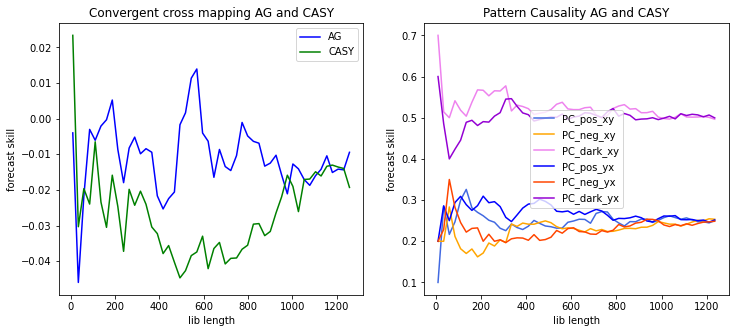

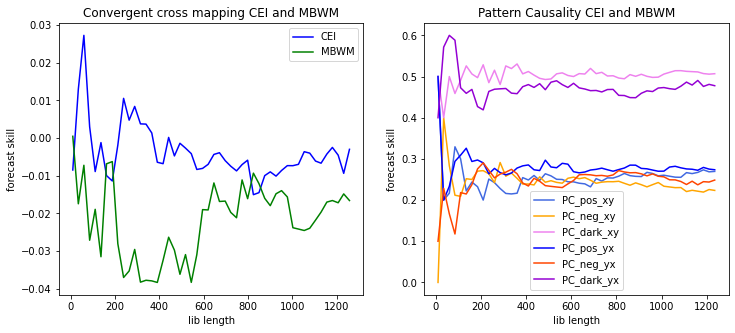

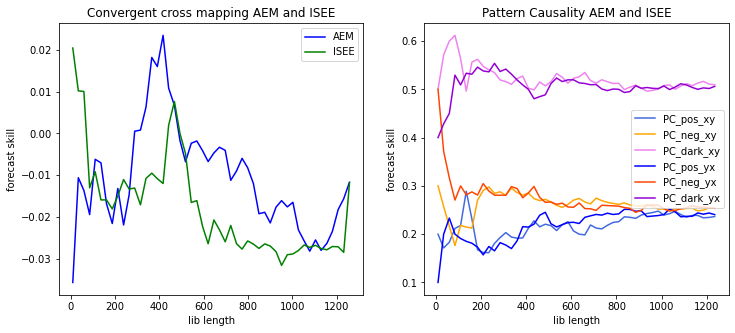

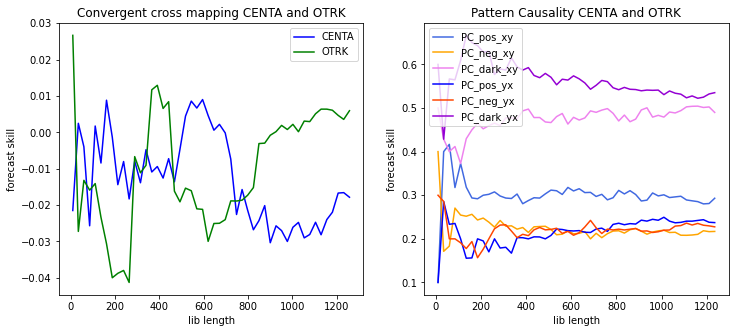

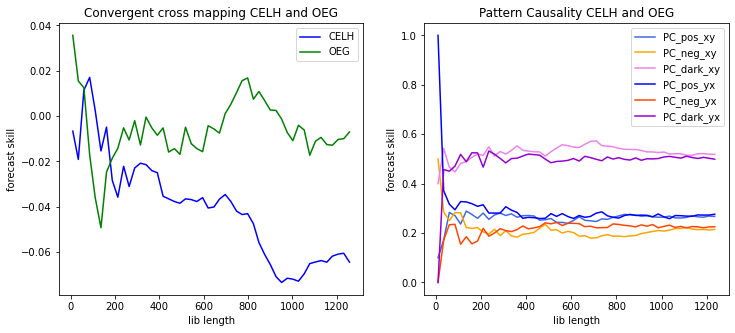

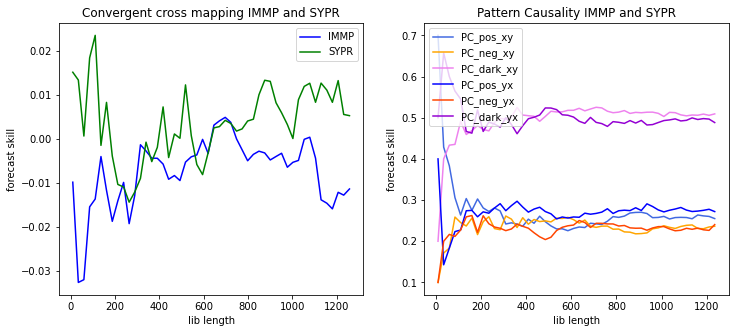

In [39]:
list2 = df2.iloc[:,:2].to_numpy()
plot_ccm_pc(list2)